In [1]:
import numpy as np
import networkx as nx
from scipy.linalg import solve
from itertools import product
from matplotlib import pyplot as plt

In [2]:
def active_set_algorithm(G, c, A, b, x0, tol=1e-6, max_iter=100):

    x = x0
    m, n = A.shape
    active_set = []

    for k in range(max_iter):
        # Check for violated constraints
        residuals = A @ x - b
        violated = np.where(residuals > tol)[0]
        # Compute gradient
        grad = G @ x + c

        if len(violated) == 0:
            # If there are no violated constraints, check optimality conditions
            if len(active_set) == 0:
                p = -solve(G, grad)
            else:
                A_eq = A[active_set]
                try:
                    W = np.block([[G, A_eq.T], [A_eq, np.zeros((len(active_set), len(active_set)))]])
                    rhs = np.block([-grad, np.zeros(len(active_set))])
                    sol = solve(W, rhs)
                    p = sol[:n]
                    lag_mul = sol[n:]
                except np.linalg.LinAlgError:
                    p = np.zeros_like(x)

            # Check for optimality (Lagrange multipliers)
                if np.all(lag_mul >= -tol):
                    # print(f'Converged in {k} iterations.')
                    return x
        else:
            p = np.zeros_like(x)

        if np.linalg.norm(p) < tol:
            # Check if Lagrange multipliers are non-negative
            if len(active_set) == 0 or np.all(lag_mul >= -tol):
                # print(f'Converged in {k} iterations.')
                return x
            min_lag_mul_idx = np.argmin(lag_mul)
            active_set.pop(min_lag_mul_idx)
        else:
            # Take a step along p
            alpha = 1.0
            active_set_candidate = None
            for j in range(m):
                if j not in active_set:
                    Aj_p = A[j] @ p
                    if Aj_p < 0:
                        # Calculate the step size alpha that would violate this constraint
                        alpha_j = -(A[j] @ x - b[j]) / Aj_p
                        if alpha_j < alpha:
                            alpha = alpha_j
                            active_set_candidate = j
            # Update solution
            x = x + alpha * p

            if active_set_candidate is not None:
                active_set.append(active_set_candidate)
                
    raise ValueError('Active set algorithm did not converge.')

In [2]:
G = np.array([[2, 0], [0, 2]])
c = np.array([-2, -5])
A = np.array([[1, -2], [-1, -2], [-1, 2], [1, 0], [0, 1]])
b = np.array([-2, -6, -2, 0, 0])
x0 = np.array([2, 0])

In [ ]:
optimal_x = active_set_algorithm(G, c, A, b, x0)

In [22]:
print("Optimal solution:", optimal_x)

Optimal solution: [1.4, 1.7]


In [2]:
def simplex_tableau(c, A, b):
    tol = 1e-14
    res = ''
    c = np.array(c)
    A = np.array(A)
    b = np.array(b)
    m, n = A.shape
    Ni = np.array(range(n - m))
    Bi = np.array(range(m)) + n - m
    x = np.zeros((n, 1))
    xB = np.array(b)

    for _ in range(4 * m):
        l = np.linalg.solve(A[:, Bi], c[Bi])
        sN = c[Ni] - np.matmul(np.transpose(A[:, Ni]), l)
        sm = np.min(sN)
        qq = np.argmin(sN)
        q = Ni[qq]
        xm = np.min(xB)
        p = np.argmin(xB)
        mu = np.minimum(sm, xm)

        if mu >= -tol:
            res = 'solution found'
            break
        if mu == sm:
            a = A[:, q]
            p = np.argmax(a)
            phi = A[p, q]
            if phi <= tol:
                res = 'primal infeasible or unbounded'
                break
        else:
            sigma = A[p, Ni]
            qq = np.argmin(sigma)
            q = Ni[qq]
            phi = A[p, q]
            if phi >= -tol:
                res = 'dual infeasible or unbounded'
        xB[p] = xB[p] / phi
        A[p, :] = A[p, :] / phi
        oi = range(m)
        oi.remove(p)
        xB[oi] = xB[oi] - A[oi, q] * xB[p]
        A[oi, :] = A[oi, :] - np.multiply.outer(A[oi, q], A[p, :])
        Ni[Ni == q] = Bi[p]
        Bi[p] = q
    x[Bi, 0] = xB
    opt = np.dot(c, x)

    if len(res) == 0:
        res = 'iters exceeded max number'
    
    return x, opt[0], res

In [3]:
def active_set_qp(x, d, G, ce, be, ci, bi, W=[]):

    tol = 1e-8
    w, v = np.linalg.eig(G)
    has_neg_eigval = np.any(w < 0)
    n = len(x)
    ni = len(ci)
    ne = len(ce)
    ce = np.array(ce)
    ci = np.array(ci)
    be = np.array(be)
    bi = np.array(bi)

    if ni == 0:
        ci = np.zeros((0, n))
    if ne == 0:
        ce = np.zeros((0, n))

    eq = ce @ x - be
    iq = ci @ x - bi

    if np.all(np.abs(eq) < tol) and np.all(iq > -tol):
        if len(W) != ni:
            W = iq < tol
    else:
        c = np.concatenate((np.zeros(2 * n), np.ones(ni + 2 * ne)))
        A = np.concatenate((np.concatenate((-ci, ci, np.eye(ni), np.zeros((ni, 2 * ne))), 1), 
                            np.concatenate((ce, -ce, np.zeros((ne, ni)), np.zeros((ne, ne))), 1), 
                            np.concatenate((-ce, ce, np.zeros((ne, ni + ne)), np.eye(ne)), 1)), 0)
        b = np.concatenate((-bi, be, -be))
        x, opt, res = simplex_tableau(c, A, b)
        x = x[0:n] - x[n:2 * n]
        W = ci * x - bi < tol
        if not res == 'solution found':
            return x, W, [], 'infeasible constraints'
            print('infeasible constraints')

    for _ in range(4 * ni + 4):
        na = np.sum(W)
        A = np.concatenate((ce, ci[W, :]), 0)
        b = np.concatenate((be, bi[W]), 0)
        c = A @ x - b
        g = d + np.matmul(G, x)
        K = np.concatenate((np.concatenate((G, A.T), 1), np.concatenate((A, np.zeros((ne + na, ne + na))), 1)), 0)
        npl = np.linalg.solve(K, np.concatenate((g, c), 0))
        p = -npl[0:n]

        if has_neg_eigval:
            cdirnegcurv = False
            Q, R = np.linalg.qr(A.T, 'complete')
            Z = Q[:, na:]
            if not Z.shape[1] == 0:
                w, v = np.linalg.eig((Z.T @ G) @ Z)
                if np.min(w) < 0:
                    dd = Z @ v[:, np.argmin(w)]
                    p = -1e-4 * np.sign(np.dot(g, dd)) * dd
                    cdirnegcurv = True
        if np.all(np.abs(p) < tol):
            lambdaW = npl[n + ne:n + ne + na]
            l = np.zeros(ni)
            l[W] = lambdaW
            if np.all(lambdaW >= -tol):
                return x, W, l, 'solution found'
            else:
                mlw = np.sort(lambdaW[lambdaW < 0])
                ri = mlw[0] == l
                if 'ac' in locals() and np.all(ri == ac) and len(mlw) > 1:
                    ri = mlw[np.ceil((len(mlw) - 1) * np.rand())] == l
                W[ri] = False
        else:
            cip = ci @ p
            bicixcip = (bi - ci @ x) / cip
            findminof = bicixcip[np.invert(W) & (cip < 0)]
            if len(findminof > 0):
                alpha = np.min(findminof)
            else:
                alpha = 1
            if alpha > 1:
                alpha = 1
            if has_neg_eigval and alpha == 1 and cdirnegcurv:
                print('problem unbounded, could not find constraint in a negative curvature direction')
                return x, W, [], 'problem unbounded, could not find constraint in a negative curvature direction'
            x = x + alpha * p
            if alpha < 1:
                ac = (alpha == bicixcip) & np.invert(W) & (cip < 0)
                W = W | ac

    print('problem unbounded, could not find constraint in a negative curvature direction')
    return x, W, l, 'problem unbounded, could not find constraint in a negative curvature direction'

In [4]:
x = [2., 0.]
d = [-2., -5.]
G = [[2., 0.], [0., 2.]]
ce = []
be = []
ci = [[1., -2.], [-1., -2.], [-1., 2.], [1., 0.], [0., 1.]]
bi = [-2., -6., -2., 0., 0.]
W = [False, False, False, False, False]
print(active_set_qp(x, d, G, ce, be, ci, bi, W))

(array([1.4, 1.7]), array([ True, False, False, False, False]), array([0.8, 0. , 0. , 0. , 0. ]), 'solution found')


In [27]:
def maxcut_qp(x, W, ci, bi, tol=1e-8):

    n = len(x)
    ni = len(ci) if ci is not None else 0
    ci = np.array(ci) if ni > 0 else np.zeros((0, n))
    bi = np.array(bi) if ni > 0 else np.zeros(0)

    G = -W / 4
    d = np.zeros(n)

    W_active = np.zeros(ni, dtype=bool)
    
    for iteration in range(100):
        
        A = ci[W_active, :] if ni > 0 else np.zeros((0, n))
        b = bi[W_active] if ni > 0 else np.zeros(0)
        
        
        K = np.block([
            [G, A.T],
            [A, np.zeros((len(A), len(A)))]
        ])
        rhs = np.concatenate([-d, b])
        solution = np.linalg.solve(K, rhs)
        
        p = solution[:n]  
        lambdas = solution[n:]  

        if np.all(np.abs(p) < tol):
            if np.all(lambdas >= -tol):
                return x, "optimal solution found"
            else:
                idx_to_remove = np.argmin(lambdas)
                W_active[idx_to_remove] = False
        else:
            alpha = 1
            for i in range(ni):
                if not W_active[i]:
                    ci_p = np.dot(ci[i], p)
                    if ci_p < 0:
                        alpha = min(alpha, (bi[i] - np.dot(ci[i], x)) / ci_p)

            x = x + alpha * p
            
            if alpha < 1:
                for i in range(ni):
                    if not W_active[i] and np.abs(np.dot(ci[i], x) - bi[i]) < tol:
                        W_active[i] = True

    return x, "iteration limit exceeded"

if __name__ == "__main__":
    W = np.array([
        [0, 1, 2],
        [1, 0, 3],
        [2, 3, 0]
    ])

    x_init = np.random.rand(3)
    ci = [[1, 1, 1]]
    bi = [1]

    x_solution, status = maxcut_qp(x_init, W, ci, bi)
    print("solution:", x_solution)
    print("status:", status)

solution: [0.55363266 0.95168332 0.38844596]
status: optimal solution found


In [36]:
if __name__ == "__main__":
    W = np.array([
        [0, 2, 1, 0, 0, 3],  
        [2, 0, 4, 0, 1, 0],  
        [1, 4, 0, 5, 0, 0],  
        [0, 0, 5, 0, 3, 2],  
        [0, 1, 0, 3, 0, 4],  
        [3, 0, 0, 2, 4, 0] 
    ])
    
    x_init = np.random.rand(6)

    ci = np.array([[1, 1, 1, 1, 1, 1]])
    bi = np.array([3])  

    max_cut_value, status = maxcut_qp(x_init, W, ci, bi)
    print(max_cut_value)

    binary_partition = np.round(max_cut_value).astype(int)
    sol = -np.dot(binary_partition, np.dot(W, binary_partition)) / 4
    print(sol)

    print("MaxCut:", -np.dot(x_init, np.dot(W, x_init)) / 4)
    print("status:", status)
    print("partition:", binary_partition.tolist())

[0.35503467 0.48788428 0.55128873 0.52396897 0.8782475  0.99518046]
-7.0
MaxCut: -5.235116600176135
status: optimal solution found
partition: [0, 0, 1, 1, 1, 1]


In [9]:
def maxcut_bruteforce(W):
    
    n = len(W)
    max_cut_value = 0
    best_partition = None

    for partition in product([0, 1], repeat=n):
        partition = np.array(partition)

        cut_value = 0
        for i in range(n):
            for j in range(i + 1, n):  
                if partition[i] != partition[j]:  
                    cut_value += W[i, j]
        
        if cut_value > max_cut_value:
            max_cut_value = cut_value
            best_partition = partition

    return max_cut_value, best_partition

if __name__ == "__main__":
    W = np.array([
        [0, 1, 2],
        [1, 0, 3],
        [2, 3, 0]
    ])

    max_cut_value, best_partition = maxcut_bruteforce(W)
    print("MaxCut:", max_cut_value)
    print("partition:", best_partition.tolist())


MaxCut: 5
partition: [0, 0, 1]


In [10]:
if __name__ == "__main__":
    W = np.array([
        [0, 2, 1, 0, 0, 3],  
        [2, 0, 4, 0, 1, 0],  
        [1, 4, 0, 5, 0, 0],  
        [0, 0, 5, 0, 3, 2],  
        [0, 1, 0, 3, 0, 4],  
        [3, 0, 0, 2, 4, 0]
    ])

    max_cut_value, best_partition = maxcut_bruteforce(W)
    print("MaxCut:", max_cut_value)
    print("partition:", best_partition.tolist())


MaxCut: 22
partition: [0, 1, 0, 1, 0, 1]


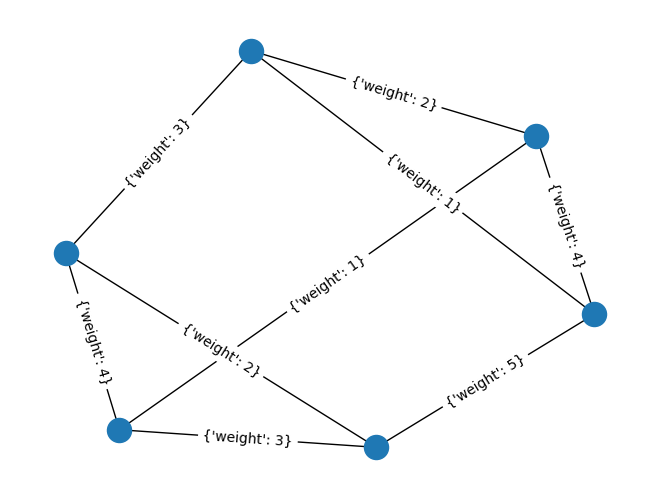

In [40]:
W = np.array([
        [0, 2, 1, 0, 0, 3],  
        [2, 0, 4, 0, 1, 0],  
        [1, 4, 0, 5, 0, 0],  
        [0, 0, 5, 0, 3, 2],  
        [0, 1, 0, 3, 0, 4],  
        [3, 0, 0, 2, 4, 0]
    ])
G = nx.from_numpy_array(W)
layout = nx.spring_layout(G)
nx.draw(G, layout)
nx.draw_networkx_edge_labels(G, pos=layout)
plt.show()

In [43]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 2}), (0, 2, {'weight': 1}), (0, 5, {'weight': 3}), (1, 2, {'weight': 4}), (1, 4, {'weight': 1}), (2, 3, {'weight': 5}), (3, 4, {'weight': 3}), (3, 5, {'weight': 2}), (4, 5, {'weight': 4})])

In [ ]:
partition: [0, 0, 1, 1, 1, 1]